# 배틀그라운드 승률 예측
<img src=https://i.pinimg.com/564x/8e/e3/5f/8ee35fa0e9f3c6afc2d7db8084c25ad6.jpg width="500">


## 주제
데이터에서 winPlacePerc(승률)을 예측하기 위해 eda 과정을 거쳐서 모델을 만들어 예측하는 프로젝트를 할려고 한다 eda는 순위와 상관관계가 있는 컬럼들을 분석하고 다른게 있으면 파생변수로 생성해서 비교하여 모델을 사용하여 예측

# **목차**
1. **패키기, 데이터 불러오기**
 <br>
 
2. **전처리**
 - NAN값, 이상치 변경(평균 값)
 - 트레인, 테스트 셋 나누기 
 
 <br>
 
3. **상관 관계**
 - 히트맵을 통해 0.3 이상의 컬럼을 통해 승률에 따른 상관 관계 그래프 분석 
 
 <br>
  
4. **모델링**
 - 회귀모델
 - 랜덤 포레스트
 - 그레이언트 부스트
 -  XGB 부스트
 - 교차 검증
 
  <br>
 
5. **하이퍼 파라미터(XGBoost bosting)**
 - 교차 검증
 
  <br>
 
6. ** 승률 예측**

 <br>
 
7. **결과**

## 사용되는 패키지

In [1]:
# 사용된 패키지
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 회귀 분석
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std 

# 예측모델 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error 

# 하이퍼 파라미터
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# 글꼴 한글 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus= False)
plt.style.use('ggplot')
pd.options.display.max_columns  = 100

# 모델링 
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.datasets import load_boston
boston = load_boston()

# 회귀
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

# Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor

print(tf.__version__)

2.2.0


## 데이터 불러오기

In [2]:
pubg = pd.read_csv('train_1.csv')
train = pubg.fillna(0)
train.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

| 컬럼 | 설명 |
|:--------:|:--------:|
| DBNOs(Down But Not Out) | 적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수 | 
|  Assists   |   	아군이 킬했을 때 같이 데미지를 넣은 수 (말 그대로 어시스트)   | 
|   Boosts  |    부스트 아이템 사용 횟수  | 
|   DamageDealt  |  총 데미지 (단, 팀에 준 피해나 자해는 포함되지 않음)    | 
|   HeadshotKills  |   헤드샷 킬 수   | 
|   Heals  |   힐링 아이템 사용 횟수   | 
|  ID   |    	플레이어 ID  | 
|   KillPlace  |  매치에서의 킬 횟수 순위    | 
|   KillPoints  |   킬 수로 산정한 ELO의 개념.  만약 rankPoints에 -1 이외의 값이 있다면, killPoints의 0값은 값이 없는 것으로 처리됨.   | 
|  KillStreaks   |  짧은 시간동안 최대한 많이 킬했을 때의 킬 수    | 
|   Kills  |    총 킬 수  | 
|  LongestKill  |  킬과 킬 사이의 이동한 가장 긴 거리    | 
|   MatchDuration  |  매치의 시간 (초 단위)    | 
|  MatchId   |   매치 ID (트레이닝 데이터와 테스트 데이터에 동일한 매치 ID는 없음)  | 
|  MatchType   |    매치 타입 “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; 나머지는 이벤트 또는 커스텀 매치  | 
|   RankPoints  |   랭킹 ELO의 개념   | 
|   Revives  |     아군 부활 횟수 | 
|  RideDistance   |   탈것으로 이동한 총 거리   | 
|  RoadKills   |    탈것으로 킬한 횟수  | 
|  SwimDistance   |   수영한 총 거리   | 
|   TeamKills  |   팀킬 횟수   | 
|   VehicleDestroys  |    차량 폭파 횟수  | 
| WalkDistance    |   걸어간 총 거리   | 
|   WeaponsAcquired  |   얻은 무기의 수   | 
|   WinPoints  |  승리 횟수로 판단한 ELO의 개념    | 
|   GroupId  |    매치 내 그룹 아이디, 동일 그룹 구성원들이 다른 게임을 할 때마다 새로운 그룹 아이디가 부여됨  | 
|  NumGroups   |   게임 내 총 그룹 수 (솔로 -> 듀오 -> 스쿼드로 갈 수록 줄어듦)   | 
|   MaxPlace  |   매치 내에서 최악의 등수  | 
|  WinPlacePerc   |  예측 목표, 1에 가까워질 수록 순위가 높아진다.  (0부터 1까지의 값으로 나타냄.  1은 1등을, 0은 꼴등을 의미한다. )    | 

<!-- ## 컬럼 설명

1. DBNOs(Down But Not Out)	적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수
2. assists	아군이 킬했을 때 같이 데미지를 넣은 수 (말 그대로 어시스트)
3. boosts	부스트 아이템 사용 횟수
4. damageDealt	총 넣은 데미지 (단, 팀에 준 피해나 자해는 포함되지 않음)
5. headshotKills	헤드샷 킬 수
6. heals	힐링 아이템 사용 횟수
7. Id	플레이어 ID
8. killPlace	매치에서의 킬 횟수 순위
9. killPoints	킬 수로 산정한 ELO의 개념.  만약 rankPoints에 -1 이외의 값이 있다면, killPoints의 0값은 값이 없는 것으로 처리됨. 
10. killStreaks	짧은 시간동안 최대한 많이 킬했을 때의 킬 수
11. kills	총 킬 수
12. longestKill	킬과 킬 사이의 이동한 가장 긴 거리
13. matchDuration	매치의 시간 (초 단위)
14. matchId	매치 ID (트레이닝 데이터와 테스트 데이터에 동일한 매치 ID는 없음)
15. matchType	매치 타입 “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; 나머지는 이벤트 또는 커스텀 매치
16. rankPoints	랭킹 ELO의 개념
17. revives	아군 부활 횟수
18. rideDistance	탈것으로 이동한 총 거리
19. roadKills	탈것으로 킬한 횟수
20. swimDistance	수영한 총 거리
21. teamKills	팀킬 횟수
22. vehicleDestroys	차량 폭파 횟수
23. walkDistance	걸어간 총 거리
24. weaponsAcquired	얻은 무기의 수
25. winPoints	승리 횟수로 판단한 ELO의 개념
26. groupId	매치 내 그룹 아이디, 동일 그룹 구성원들이 다른 게임을 할 때마다 새로운 그룹 아이디가 부여됨
27. numGroups	게임 내 총 그룹 수 (솔로 -> 듀오 -> 스쿼드로 갈 수록 줄어듦)
28. maxPlace	매치 내에서 최악의 등수
29. winPlacePerc	예측 목표, 1에 가까워질 수록 순위가 높아진다.  (0부터 1까지의 값으로 나타냄.  1은 1등을, 0은 꼴등을 의미한다. ) -->

### 매치 타입

47687


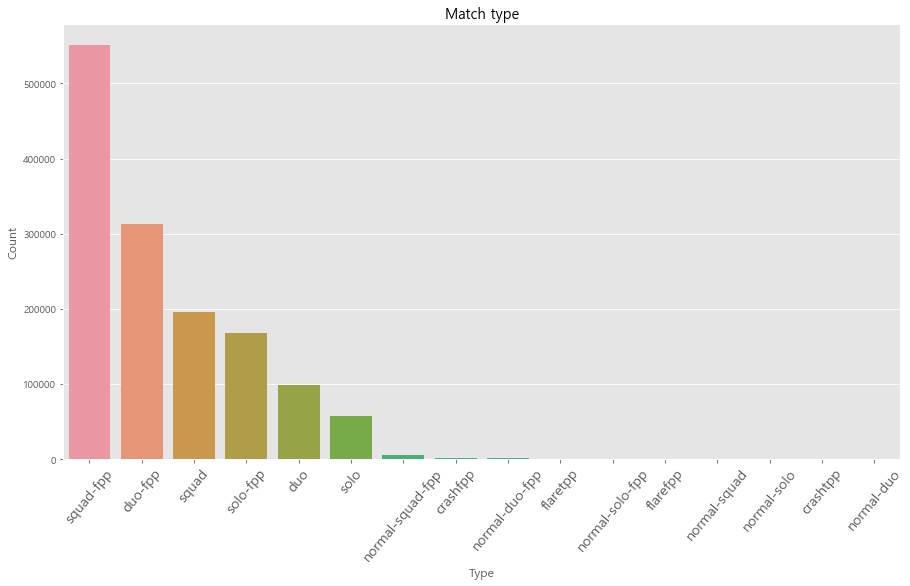

,count
solo,225859
duo,412812
squad,752377


In [3]:
# 몇개의 경기가 있는지 확인
matches_count = train.loc[:,"matchId"].nunique()
print(format(matches_count))
# 매치타입에 어떤것들이 있는지 확인
m_type = train.loc[:,"matchType"].value_counts().to_frame().reset_index()
m_type.columns = ["Type","Count"]
m_type
# train에는 기본적으로 솔로,듀오,스쿼드 이렇게 3가지 모드가 있습니다.
# FPP - First Person Perspective 1인칭
# TPP - Thirst Peron Perspective 3인칭
# Normal - 게임중에도 변환할수는 있다
# 매치타입별로 barplot
plt.figure(figsize=(15,8))
ticks = m_type.Type.values
ax = sns.barplot(x="Type", y="Count", data=m_type)
ax.set_xticklabels(ticks, rotation=50, fontsize=14) # tick은 축에 표시되는걸 말한다
ax.set_title("Match type")
plt.show()
# 솔로, 듀오, 스쿼드로 나누기
m_type2 = train.loc[:,"matchType"].value_counts().to_frame()
solo = m_type2.loc[["solo-fpp","solo","normal-solo-fpp","normal-solo"],"matchType"].sum()
duos = m_type2.loc[["duo-fpp","duo","normal-duo-fpp","normal-duo"],"matchType"].sum()
squads = m_type2.loc[["squad-fpp","squad","normal-squad-fpp","normal-squad"],"matchType"].sum()
mode = pd.DataFrame([solo, duos, squads], index=["solo","duo","squad"], columns = ["count"])
mode

### 매치 비율
그룹별로 나워 보았을때 솔로, 듀오, 스쿼드로 나눠 졌을때 사람들은 스쿼드를 가장 많이 선호하는것으로 보인다.

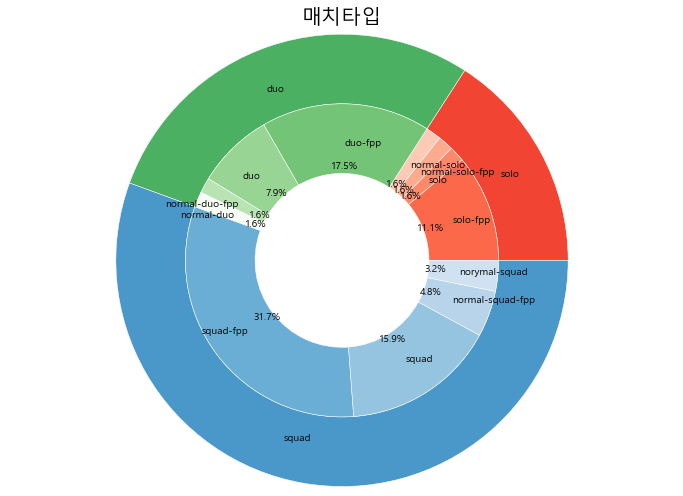

In [5]:
# 모드별로 파이차트
# importing library and set figure size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
# info. of groups
group_names = ['solo', 'duo', 'squad']
group_sizes = [10, 18, 35]
# info. of subgroups
subgroup_names = ["solo-fpp","solo","normal-solo-fpp","normal-solo",
                  "duo-fpp","duo","normal-duo-fpp","normal-duo",
                  "squad-fpp","squad","normal-squad-fpp","norymal-squad"]

subgroup_sizes = [ 7, 1, 1, 1,11, 5, 1, 1, 20, 10, 3, 2]
# colors
a, b, c = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]
# width
width_num = 0.4
# Outside Ring
fig, ax = plt.subplots()
ax.axis('equal')
pie_outside, _ = ax.pie(group_sizes,
                        radius=1.3,
                        labels=group_names,
                        labeldistance=0.8,
                        colors=[a(0.6), b(0.6), c(0.6)])
plt.setp(pie_outside,
         width=width_num,
         edgecolor='white')
# Inside Ring
pie_inside, plt_labels, junk = \
    ax.pie(subgroup_sizes,
           radius=(1.3 - width_num),
           labels=subgroup_names,
           labeldistance=0.75,
           autopct='%1.1f%%',
           colors=[a(0.5), a(0.4), a(0.3), a(0.2),
                   b(0.5), b(0.4), b(0.3), b(0,2),
                   c(0.5), c(0.4), c(0.3), c(0.2)])
plt.setp(pie_inside,
         width=width_num,
         edgecolor='white')
plt.title('매치타입', fontsize=20,pad=20)
plt.show()

배틀그라운드는 한번의 게임이 실행될 때 100 명의 플레이어가 동일한 서버에 참여하므로 듀오의 경우 최대 팀은 50이고 스쿼드의 경우 최대 팀은 25입니다.

### 데미지 (damageDealt)

{'whiskers': [<matplotlib.lines.Line2D at 0x12f642d22c8>,
 'caps': [<matplotlib.lines.Line2D at 0x12f642d2148>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f642d2a08>],
 'medians': [<matplotlib.lines.Line2D at 0x12f639ed4c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f61f2e3c8>],
 'means': []}

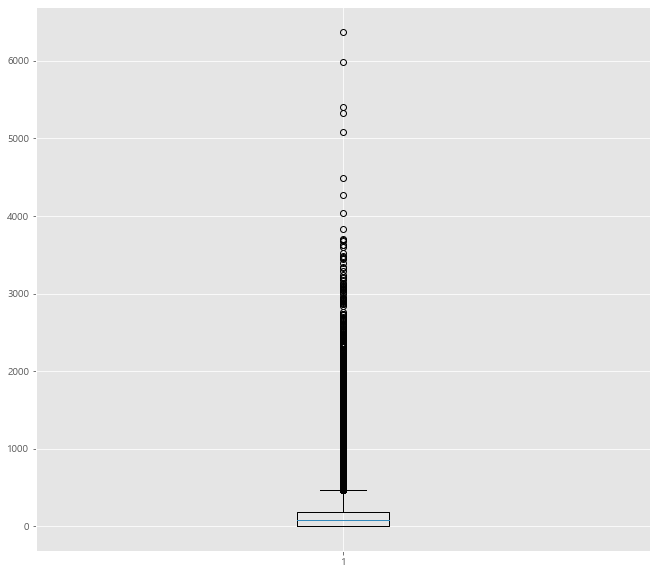

In [6]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'damageDealt')

{'whiskers': [<matplotlib.lines.Line2D at 0x12f65815f48>,
 'caps': [<matplotlib.lines.Line2D at 0x12f65814288>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f658158c8>],
 'medians': [<matplotlib.lines.Line2D at 0x12f657f5d08>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f657f5ac8>],
 'means': []}

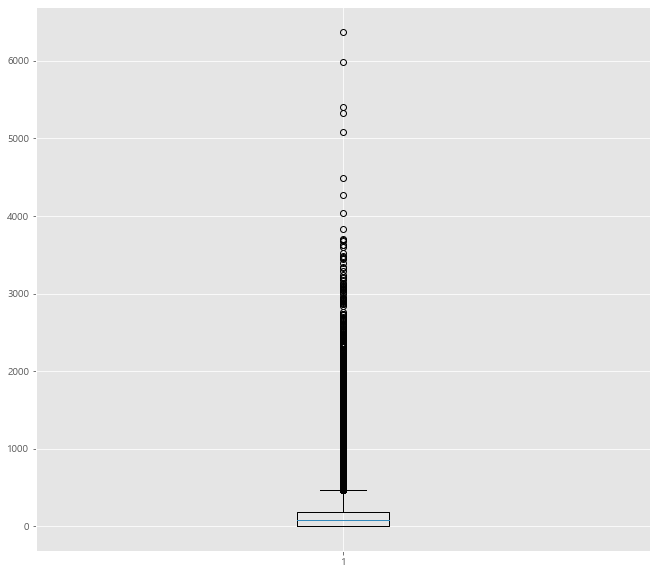

In [7]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'damageDealt')

박스 플랏을 보면 이상치가 있지만 밀집해잇기 때문에 어뷰징 또는 오류 사하항이라고는 이야기 할 수 없다.

### DBNOs

{'whiskers': [<matplotlib.lines.Line2D at 0x12f642d6f88>,
 'caps': [<matplotlib.lines.Line2D at 0x12f7893b408>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f642d67c8>],
 'medians': [<matplotlib.lines.Line2D at 0x12f789304c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f78930708>],
 'means': []}

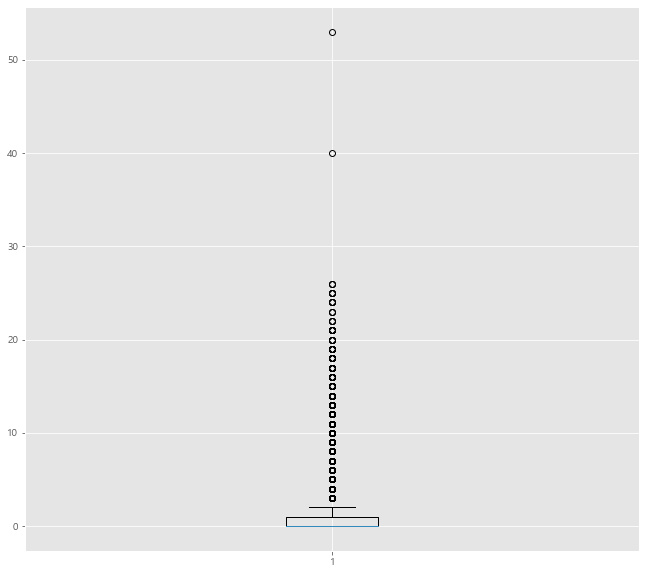

In [8]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'DBNOs')

{'whiskers': [<matplotlib.lines.Line2D at 0x12f718a7ec8>,
 'caps': [<matplotlib.lines.Line2D at 0x12f718ddb48>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f718a7708>],
 'medians': [<matplotlib.lines.Line2D at 0x12f718d8548>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f718d8788>],
 'means': []}

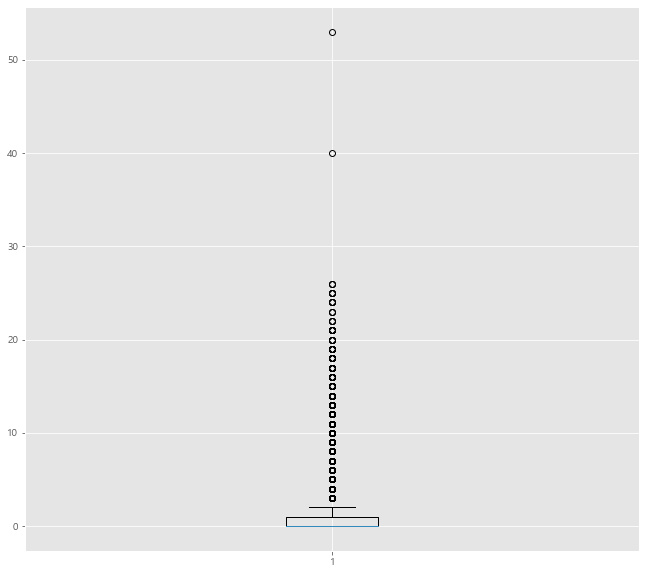

In [9]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'DBNOs')

### 킬 수  (kills)

{'whiskers': [<matplotlib.lines.Line2D at 0x12f626a5208>,
 'caps': [<matplotlib.lines.Line2D at 0x12f626b76c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f626a5a88>],
 'medians': [<matplotlib.lines.Line2D at 0x12f626cd548>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f626cdac8>],
 'means': []}

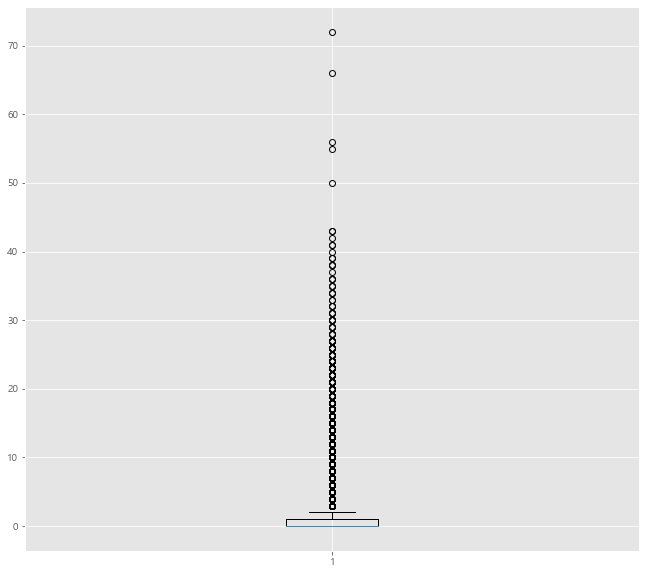

In [10]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'kills')

평균적으로 1킬이하를 하는데 50킬 이상하는 플레이어도 있다(이상치) 한게임에 최대 100명이 플레이를 하는데 그 중에 한플레이어가 최대로 할수있는 킬이 몇킬인지 기준을 정할수 없기에 이상치로 판단이되어 평균값을 넣었다.

{'whiskers': [<matplotlib.lines.Line2D at 0x12f700337c8>,
 'caps': [<matplotlib.lines.Line2D at 0x12f70033b48>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f70048048>],
 'medians': [<matplotlib.lines.Line2D at 0x12f70037888>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f70037fc8>],
 'means': []}

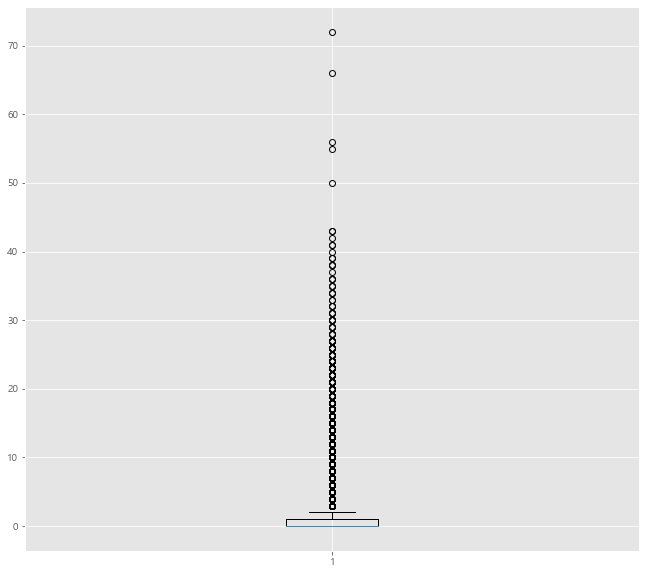

In [11]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'kills')

### 헤드샷 (headshotKills)

{'whiskers': [<matplotlib.lines.Line2D at 0x12f74e40f88>,
 'caps': [<matplotlib.lines.Line2D at 0x12f74e435c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f74e407c8>],
 'medians': [<matplotlib.lines.Line2D at 0x12f74e43048>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f74e7a848>],
 'means': []}

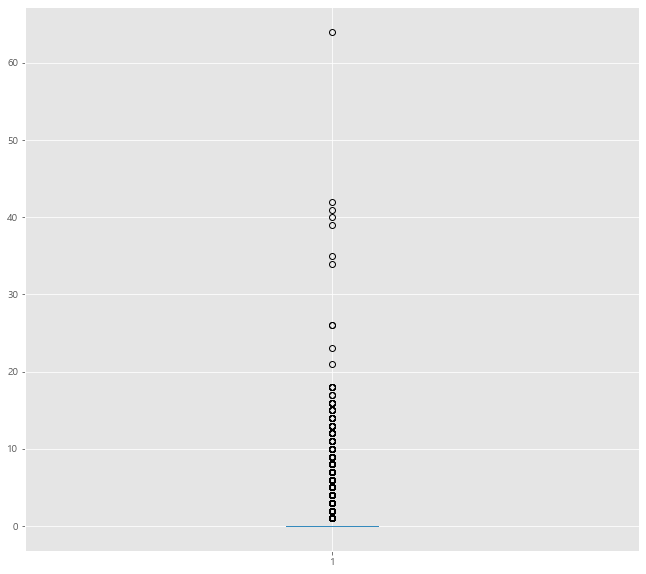

In [12]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'headshotKills')

{'whiskers': [<matplotlib.lines.Line2D at 0x12f7036bb88>,
 'caps': [<matplotlib.lines.Line2D at 0x12f7036bf08>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f7036b3c8>],
 'medians': [<matplotlib.lines.Line2D at 0x12f7038c2c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f6e8c2ec8>],
 'means': []}

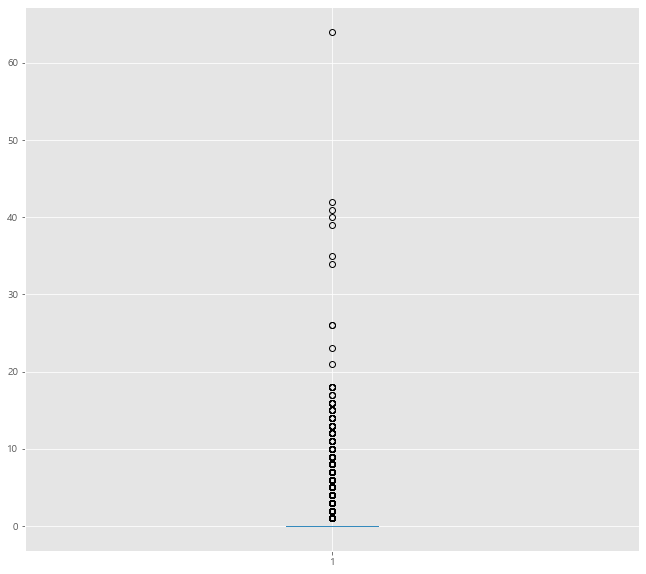

In [13]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'headshotKills')

### 짧은 시간동안 최대한 많이 킬했을 때의 킬 수 (killStreaks) 

{'whiskers': [<matplotlib.lines.Line2D at 0x12f6c8a8a88>,
 'caps': [<matplotlib.lines.Line2D at 0x12f6c8a8e08>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f6c8a82c8>],
 'medians': [<matplotlib.lines.Line2D at 0x12f6c8a3488>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f6c89d308>],
 'means': []}

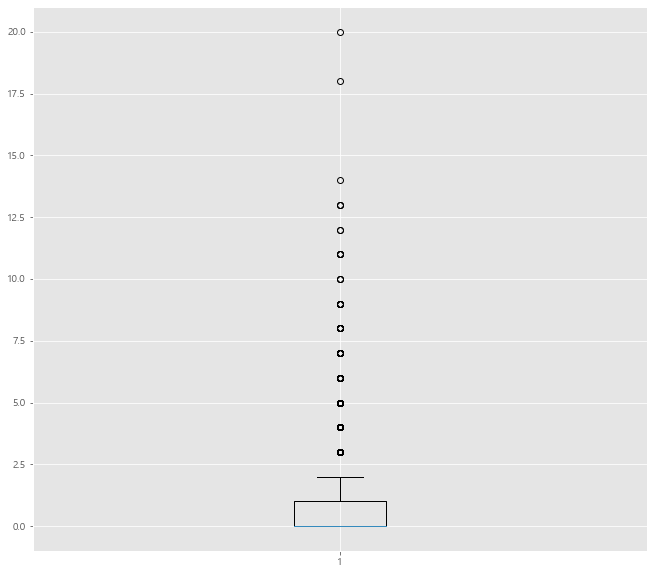

In [14]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'killStreaks')

위의 [killStreaks]를 보았을때 연속적으로 20명을 죽인 기록이 있다. 하지만 게임에서 짧은 시간내에 20명을 연속 적으로죽이는 것은 불가능 하다고 판단 된다. 평균이 0.543864 인 수치와 75%에 해당하는 사람들 또한 1명을 연속적으로 죽이기때문이다.

연속된 킬수의 분포도를 보니 0-11 킬 수 까지는 고르게 분포되어 있는 반면 12-20킬 까지는 1명씩으로 되어있으며 핵이나 오류사항으로 판단해 평균 수치로 전환한다.

{'whiskers': [<matplotlib.lines.Line2D at 0x12f73924948>,
 'caps': [<matplotlib.lines.Line2D at 0x12f73924588>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f739291c8>],
 'medians': [<matplotlib.lines.Line2D at 0x12f73920a88>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f7391a208>],
 'means': []}

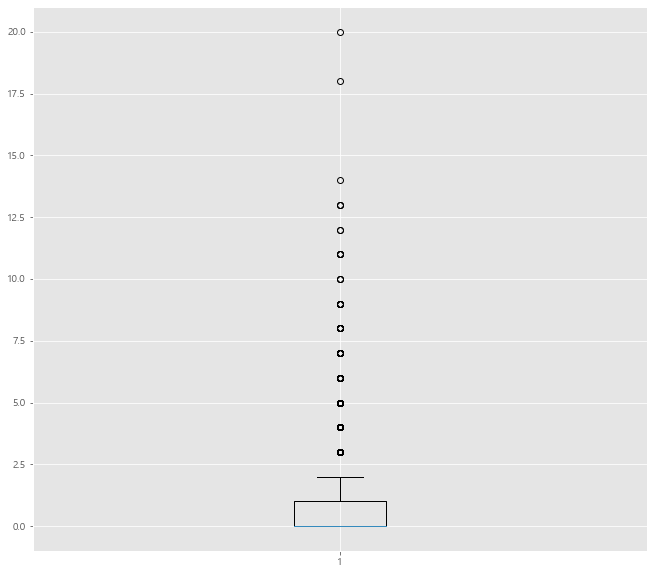

In [15]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'killStreaks')

# 이상치 예외 컬럼
- 이상치로 보이나 해당되는 데이터를 보았을때 가능한 수치이다.

### 어시스트 (assists)

{'whiskers': [<matplotlib.lines.Line2D at 0x12f607dcf88>,
 'caps': [<matplotlib.lines.Line2D at 0x12f607db2c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f607dc688>],
 'medians': [<matplotlib.lines.Line2D at 0x12f607d91c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f607d9488>],
 'means': []}

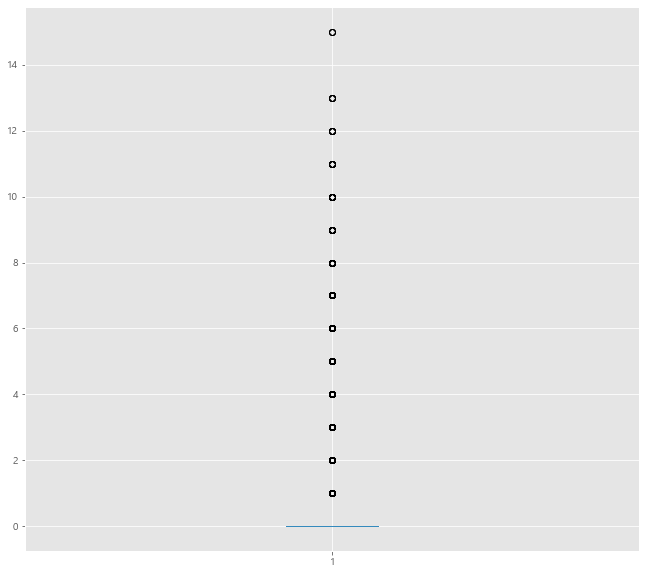

In [16]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'assists')

### 부스트 (boosts)

{'whiskers': [<matplotlib.lines.Line2D at 0x12f5ed28a08>,
 'caps': [<matplotlib.lines.Line2D at 0x12f5ed28688>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f5ed2bd88>],
 'medians': [<matplotlib.lines.Line2D at 0x12f5ed24748>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f5d2613c8>],
 'means': []}

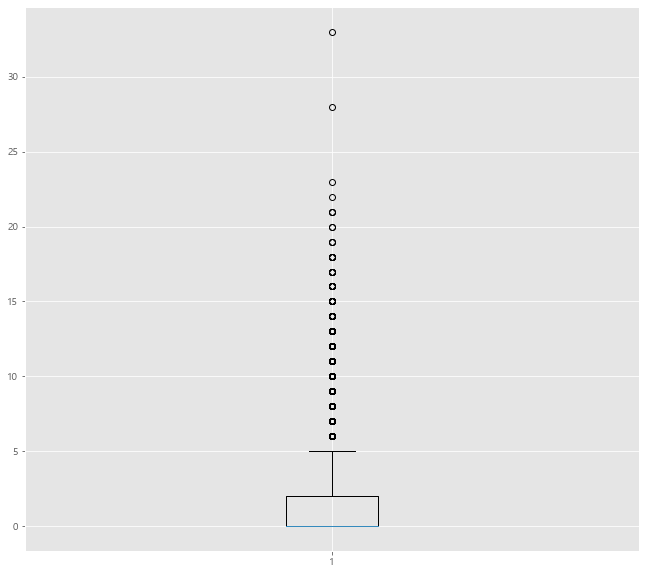

In [17]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'boosts')

In [18]:
train[train['boosts'] > 20][[ 'assists', 'boosts', 'heals', 'kills','rideDistance', 'walkDistance']]

,assists,boosts,heals,kills,rideDistance,walkDistance
18715,1,21,3,2,852.5,3197.0
141075,0,33,3,8,0.0,2790.0
480119,0,28,13,0,0.0,2488.0
589638,0,21,17,0,0.0,1586.0
618627,2,23,7,4,1760.0,2793.0
620041,0,22,0,3,0.0,2499.0
821772,1,21,2,7,2285.0,2207.0


### 치료 (heals)

{'whiskers': [<matplotlib.lines.Line2D at 0x12f5bd28a48>,
 'caps': [<matplotlib.lines.Line2D at 0x12f5bd28dc8>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f5bd28288>],
 'medians': [<matplotlib.lines.Line2D at 0x12f5bd23288>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f5bd1e088>],
 'means': []}

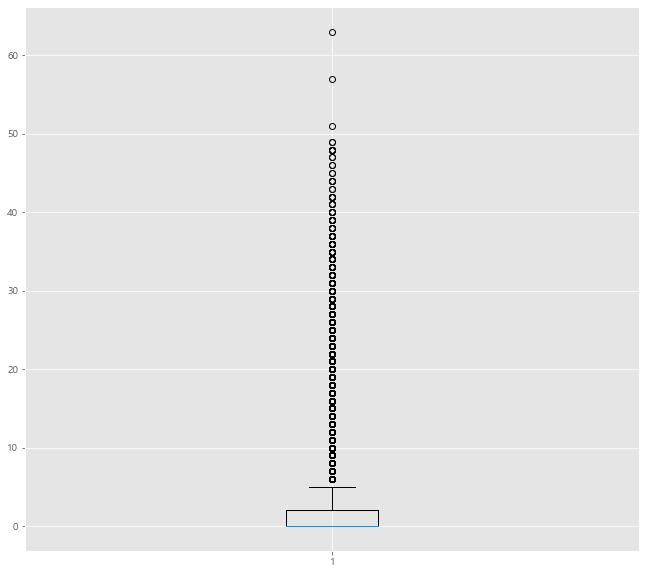

In [19]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'heals')

In [20]:
train[train['heals'] > 50][[ 'assists', 'boosts', 'heals', 'kills','rideDistance', 'walkDistance', 'weaponsAcquired']]

,assists,boosts,heals,kills,rideDistance,walkDistance,weaponsAcquired
252290,0,5,57,0,2583.0,3003.0,5
311872,0,6,63,0,3906.0,1752.0,4
884526,0,4,51,0,2416.0,3992.0,4


###  무기 획득 수 (weaponsAcquired) 

{'whiskers': [<matplotlib.lines.Line2D at 0x12f5a27eac8>,
 'caps': [<matplotlib.lines.Line2D at 0x12f5a27ee48>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f5a27e308>],
 'medians': [<matplotlib.lines.Line2D at 0x12f5a27ad88>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f5a276f08>],
 'means': []}

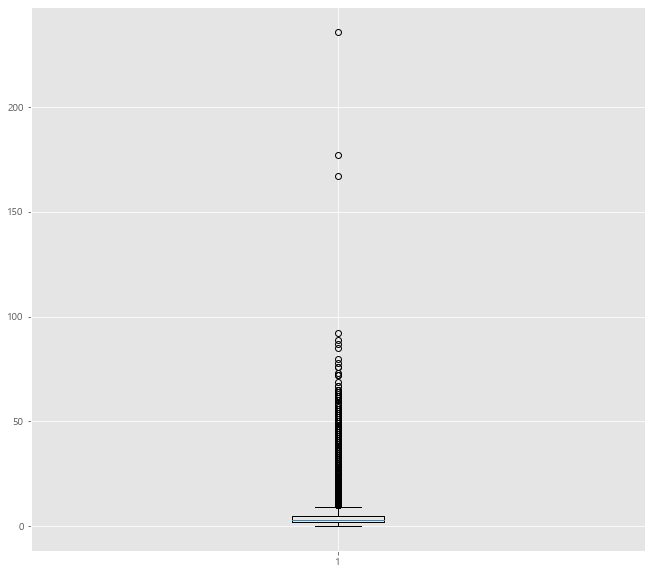

In [21]:
plt.figure(figsize=(11,10))
plt.boxplot(data= train, x= 'weaponsAcquired')

In [22]:
train[train['weaponsAcquired'] > 150][['heals', 'damageDealt', 'DBNOs','headshotKills', 'heals', 'kills', 'killStreaks','rideDistance', 'walkDistance','weaponsAcquired']]

,heals,damageDealt,DBNOs,headshotKills,heals,kills,killStreaks,rideDistance,walkDistance,weaponsAcquired
859834,2,186.90,2,0,2,2,2,1675.0,1643.0,167
861823,5,378.90,2,0,5,3,1,303.7,3338.0,177
934978,2,85.85,0,0,2,0,0,4778.0,2112.0,236


이상치로 의심이 드나 데이터를 확인해보았을때 생존을 위해 파밍만을 하다 게임이 종료 된것으로 보인다.

이상치를 평균 값으로 제거 후 게임에서 최고 획득 아이템개수는 92개로 보인다.

## 이상치 평균값으로 변경

- 이상치 변경(평균 값)

### 이상치 컬럼 확인

In [23]:
# 데미지
train[train['damageDealt'] > 5000] [['headshotKills','kills','longestKill','weaponsAcquired','DBNOs','damageDealt','killStreaks','walkDistance']].sort_values(by='damageDealt', ascending=False)

# DBNO
train[train['DBNOs'] > 30][['headshotKills','kills','longestKill','weaponsAcquired','DBNOs','damageDealt','killStreaks','walkDistance']].sort_values(by='DBNOs', ascending=False)

# 킬수 
train[train['kills'] >50][['headshotKills','kills','longestKill','weaponsAcquired','DBNOs','damageDealt','killStreaks','walkDistance']].sort_values(by='kills', ascending=False)

# 헤드샷
train[train['headshotKills'] > 20][['headshotKills','kills','longestKill','weaponsAcquired','DBNOs','damageDealt','killStreaks','walkDistance']].sort_values(by='headshotKills', ascending=False)

# 연속킬 
train[train['killStreaks']> 11][['headshotKills','kills','longestKill','weaponsAcquired','DBNOs','damageDealt','killStreaks','walkDistance']].sort_values(by='killStreaks', ascending=False)

,headshotKills,kills,longestKill,weaponsAcquired,DBNOs,damageDealt,killStreaks,walkDistance
1230936,35,40,621.800,2,0,3680.0,20,1180.00
906157,1,20,64.290,4,0,2074.0,18,3150.00
1152019,41,55,310.300,17,53,5330.0,14,12.19
690649,13,16,117.200,4,0,1670.0,13,1744.00
856874,0,14,7.181,0,0,1246.0,13,1277.00
970086,14,15,33.200,2,0,1436.0,13,968.90
312771,9,15,37.240,2,0,1651.0,12,1074.00
743690,12,13,45.940,5,0,1334.0,12,607.80


### 이상치 해당걸음거리에 따른 평균

In [24]:
train[train['walkDistance']== 1180.00 ]['headshotKills'].mean()

0.3619402985074627

### 이상치 변경

In [25]:
# 데미지
train.loc[(train['walkDistance']==0.00) & (train['damageDealt']== 5090.0), 'damageDealt']=17.539109149636957
train.loc[(train['walkDistance']==287.50) & (train['damageDealt']== 5406.0), 'damageDealt']=187.56426470588227
train.loc[(train['walkDistance']==728.10) & (train['damageDealt']== 5990.0), 'damageDealt']=245.63707317073172
train.loc[(train['walkDistance']==1740.00) & (train['damageDealt']== 6375.0), 'damageDealt']=188.29076470588234
train.loc[(train['walkDistance']==12.19) & (train['damageDealt']== 5330.0), 'damageDealt']=246.5908695652174

# DBNOs
train.loc[(train['walkDistance']==80.40) & (train['DBNOs']== 40), 'DBNOs']=1.1290322580645162
train.loc[(train['walkDistance']==12.19) & (train['DBNOs']== 53), 'DBNOs']=3.5

# 킬수 
train.loc[(train['walkDistance']==287.50) & (train['kills']== 56), 'kills']= 1.6029411764705883
train.loc[(train['walkDistance']==728.10) & (train['kills']== 72), 'kills']= 2.4878048780487805
train.loc[(train['walkDistance']==1740.00) & (train['kills']== 66), 'kills']= 1.4509803921568627
train.loc[(train['walkDistance']==12.19) & (train['kills']== 55), 'kills']= 2.4347826086956523
train.loc[(train['walkDistance']==1021.00) & (train['kills']== 50), 'kills']= 1.0890410958904109

# 헤드샷
train.loc[(train['walkDistance']==728.10) & (train['headshotKills']== 64), 'headshotKills']= 1.7317073170731707
train.loc[(train['walkDistance']==1740.00) & (train['headshotKills']== 21), 'headshotKills']= 0.34509803921568627
train.loc[(train['walkDistance']==972.80) & (train['headshotKills']== 39), 'headshotKills']= 1.6923076923076923
train.loc[(train['walkDistance']==80.40) & (train['headshotKills']== 34), 'headshotKills']= 1.8421052631578947
train.loc[(train['walkDistance']==12.19) & (train['headshotKills']== 41), 'headshotKills']= 1.7826086956521738
train.loc[(train['walkDistance']==718.30) & (train['headshotKills']== 40), 'headshotKills']= 1.8695652173913044
train.loc[(train['walkDistance']==98.04) & (train['headshotKills']== 26), 'headshotKills']= 1.4736842105263157
train.loc[(train['walkDistance']==1021.00) & (train['headshotKills']== 42), 'headshotKills']= 0.3253424657534247
train.loc[(train['walkDistance']==205.90) & (train['headshotKills']== 23), 'headshotKills']= 0.32038834951456313
train.loc[(train['walkDistance']==0.00) & (train['headshotKills']== 26), 'headshotKills']= 0.0204035946144744
train.loc[(train['walkDistance']==1180.00) & (train['headshotKills']== 35), 'headshotKills']= 0.3619402985074627

# 연속킬
train.loc[(train['walkDistance']== 1180.00) & (train['killStreaks']== 20), 'killStreaks']= 0.6604477611940298
train.loc[(train['walkDistance']== 3150.00) & (train['killStreaks']== 18), 'killStreaks']= 1.102189781021898
train.loc[(train['walkDistance']== 12.19) & (train['killStreaks']== 14), 'killStreaks']= 0.6521739130434783
train.loc[(train['walkDistance']== 1744.00) & (train['killStreaks']== 13), 'killStreaks']= 0.7518248175182481
train.loc[(train['walkDistance']== 1277.00) & (train['killStreaks']== 13), 'killStreaks']= 0.6691449814126395
train.loc[(train['walkDistance']== 968.90) & (train['killStreaks']== 13), 'killStreaks']= 1.1111111111111112
train.loc[(train['walkDistance']== 1074.00) & (train['killStreaks']== 12), 'killStreaks']= 0.6052631578947368
train.loc[(train['walkDistance']== 607.80)  & (train['killStreaks']== 12), 'killStreaks']= 0.6222222222222222
train.loc[(train['walkDistance']== 1117.00)  & (train['killStreaks']== 11.0), 'killStreaks']= 0.6571428571428571
train.loc[(train['walkDistance']== 1609.00 )  & (train['killStreaks']==  11.0), 'killStreaks']= 0.7167235494880546
train.loc[(train['walkDistance']==  751.60)  & (train['killStreaks']==  11.0), 'killStreaks']= 1.0
train.loc[(train['walkDistance']== 98.04)  & (train['killStreaks']==  11.0), 'killStreaks']= 0.8947368421052632
train.loc[(train['walkDistance']== 310.10)  & (train['killStreaks']==  11.0), 'killStreaks']= 0.5384615384615384

## 상관관계 

각 데이터와 우리가 예측해야할 목표인 winPlacePerc winPlacePerc와 각 Column들을 비교하기 위해 
x축으로는 winPlacePerc를 넣고 y축에는 알고자하는 columns를 넣어 데이터가찍히는것을 분석.

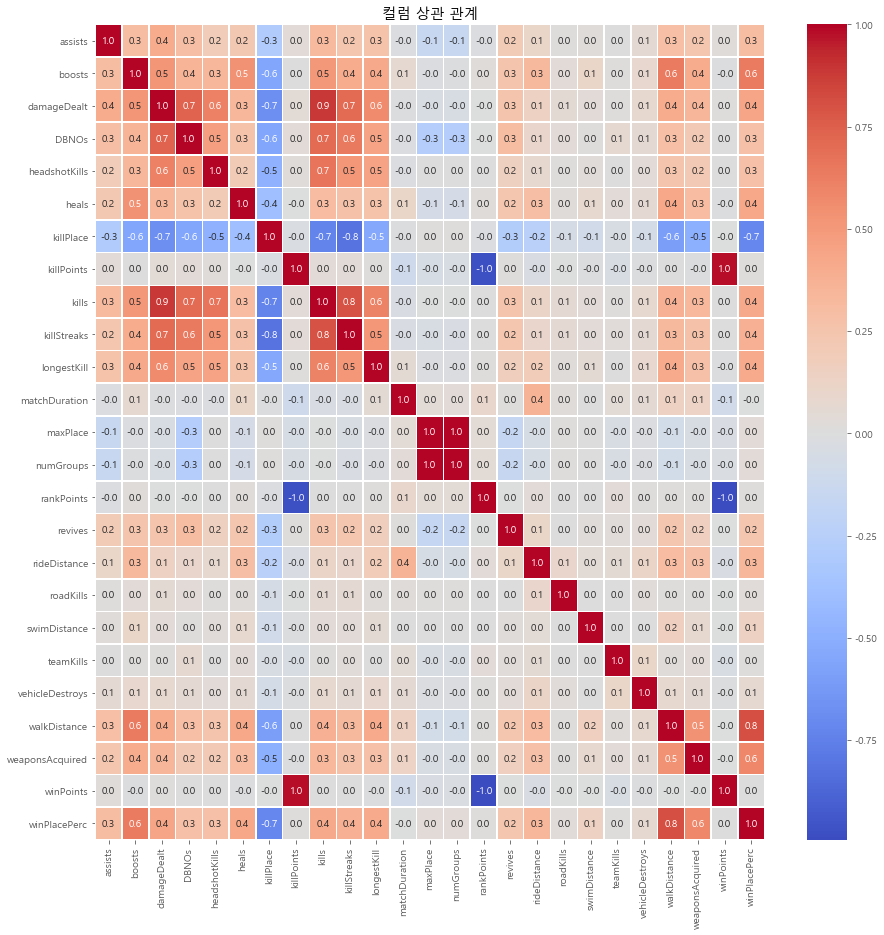

assists과 winPlacePerc의 상관관계 : 0.29944811540493643

boosts과 winPlacePerc의 상관관계 : 0.6341127444114487

heals과 winPlacePerc의 상관관계 : 0.42769200124692813

damageDealt과 winPlacePerc의 상관관계 : 0.44184552960000045

DBNOs과 winPlacePerc의 상관관계 : 0.28095911584255423

kills과 winPlacePerc의 상관관계 : 0.42146065898956075

headshotKills과 winPlacePerc의 상관관계 : 0.27989028870599975

killStreaks과 winPlacePerc의 상관관계 : 0.3783738879169966

longestKill과 winPlacePerc의 상관관계 : 0.41006200075108035

rideDistance과 winPlacePerc의 상관관계 : 0.3430971799022607

walkDistance과 winPlacePerc의 상관관계 : 0.8109147127839471

weaponsAcquired과 winPlacePerc의 상관관계 : 0.5831108266069956

winPlacePerc과 winPlacePerc의 상관관계 : 0.9999999999999998



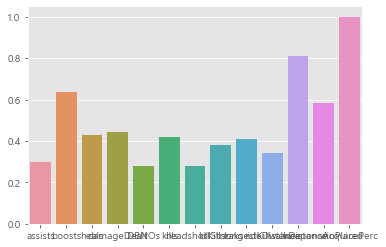

In [26]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap='coolwarm')
plt.title('컬럼 상관 관계')
plt.show()

train1 = train [['assists', 'boosts', 'heals', 'damageDealt','DBNOs', 'kills', 'headshotKills', 'killStreaks','longestKill', 'rideDistance','walkDistance','weaponsAcquired', 'winPlacePerc']]

corr_bar = []
for column in train1.columns:
    print(f'{column}과 winPlacePerc의 상관관계 : {train1["winPlacePerc"].corr(train[column])}\n')
    corr_bar.append(train1["winPlacePerc"].corr(train1[column]))
    
train_corr_bar = sns.barplot(train1.columns, corr_bar)

## 승률 직접적인 상관관계 요소

### 걸어서 이동한거리 (walkDistance)

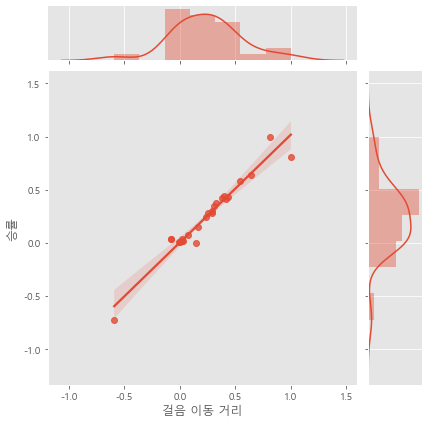

평균적인 걸음 이동거리 는  1154.2037의 수치이다., 99% 의 사람들은 4400.0이동을 하였으며  가장 많이 이동한 걸음 는  16250.0이다..


In [27]:
sns.jointplot(data=train.corr(), x= 'walkDistance', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('걸음 이동 거리')
plt.ylabel('승률')
plt.grid()
plt.show()

print("평균적인 걸음 이동거리 는  {:.4f}의 수치이다., 99% 의 사람들은 {}이동을 하였으며  가장 많이 이동한 걸음 는  {}이다.."
      .format(train['walkDistance'].mean(),train['walkDistance'].quantile(0.99), train['walkDistance'].max()))

In [28]:
train[train['walkDistance']>16000][['assists', 'boosts', 'heals', 'damageDealt','DBNOs', 'kills', 'headshotKills', 'killStreaks','longestKill','walkDistance','weaponsAcquired']]

,assists,boosts,heals,damageDealt,DBNOs,kills,headshotKills,killStreaks,longestKill,walkDistance,weaponsAcquired
563393,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,16250.0,3


### 어시스트 (assists)

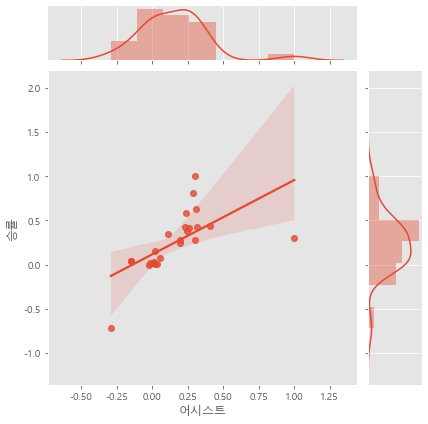

평균적인 어시스트 횟수는  0.2332 명의 플레이어를 어시스트의 수치이다., 99% 의 사람들은 3.0명, 1%에 속하는 사람들의  어시스트 도움을 주는 사람은  15명이다..


In [29]:
sns.jointplot(data=train.corr(), x= 'assists', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('어시스트')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 어시스트 횟수는  {:.4f} 명의 플레이어를 어시스트의 수치이다., 99% 의 사람들은 {}명, 1%에 속하는 사람들의  어시스트 도움을 주는 사람은  {}명이다.."
      .format(train['assists'].mean(),train['assists'].quantile(0.99), train['assists'].max()))

### 부스트 (boosts)

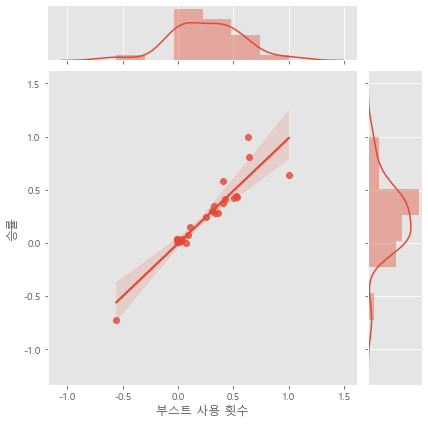

평균적인 사람은 1.1 부스트 아이템을, 99% 의 사람들이 7.0 이하를 사용하며 의사는 33개를 사용했습니다.


In [30]:
sns.jointplot(data=train.corr(), x= 'boosts', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('부스트 사용 횟수')
plt.ylabel('승률')
plt.grid()
plt.show()

print("평균적인 사람은 {:.1f} 부스트 아이템을, 99% 의 사람들이 {} 이하를 사용하며 의사는 {}개를 사용했습니다.".format(train['boosts'].mean(), train['boosts'].quantile(0.99), train['boosts'].max()))

### 치료 (heals)

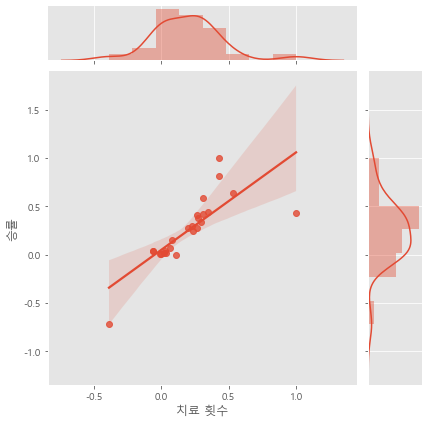

평균적인 사람은 1.4 치료 아이템을, 99% 의 사람들이 12.0 이하를 사용하며 의사는 63개를 사용했습니다.


In [31]:
sns.jointplot(data=train.corr(), x= 'heals', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('치료 횟수')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 사람은 {:.1f} 치료 아이템을, 99% 의 사람들이 {} 이하를 사용하며 의사는 {}개를 사용했습니다.".format(train['heals'].mean(), train['heals'].quantile(0.99), train['heals'].max()))

### 데미지 (damageDealt)

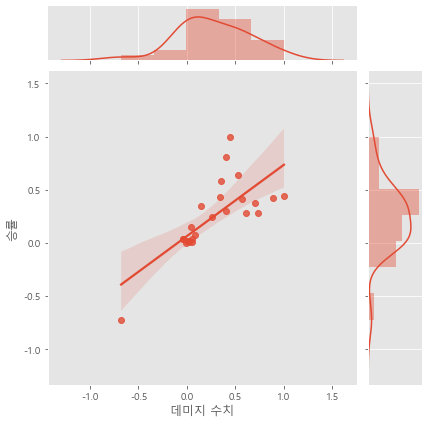

평균적인 사람은 130.7 데미지를 주었으며 , 99% 의 사람들은 774.8729999999981 이하의 데미지를 주었으며 가장많이 가한 데이미지는 4495.0 입니다.


In [32]:
sns.jointplot(data=train.corr(), x= 'damageDealt', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('데미지 수치')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 사람은 {:.1f} 데미지를 주었으며 , 99% 의 사람들은 {} 이하의 데미지를 주었으며 가장많이 가한 데이미지는 {} 입니다.".format(train['damageDealt'].mean(), train['damageDealt'].quantile(0.99), train['damageDealt'].max()))

### 기절시킨횟수 ( DBNOs 솔로 제외 )

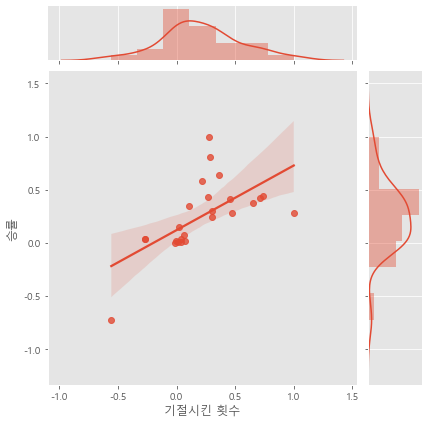

평균적인 기절시킨 횟수는  0.6572 명의 플레이어를 기절시킨 수치이다., 99% 의 사람들은 5.0명 이하의 기절을 시키지만 기록한 반면에 가장 많이 킬수는  26.0명이다..


In [33]:
sns.jointplot(data=train.corr(), x= 'DBNOs', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('기절시킨 횟수')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 기절시킨 횟수는  {:.4f} 명의 플레이어를 기절시킨 수치이다., 99% 의 사람들은 {}명 이하의 기절을 시키지만 기록한 반면에 가장 많이 킬수는  {}명이다.."
      .format(train['DBNOs'].mean(),train['DBNOs'].quantile(0.99), train['DBNOs'].max()))

### 킬 수 (kills)

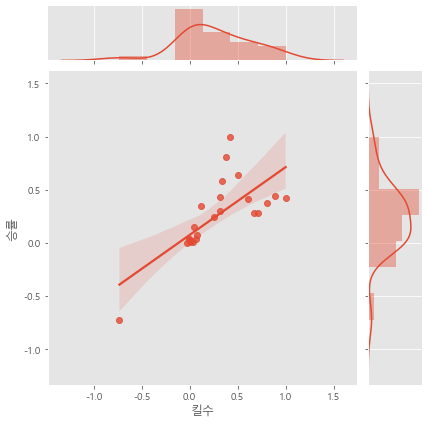

평균적인 사람의 킬 수는  0.9238 명의 플레이어의 수치이다., 99% 의 사람들은 7.0 명 이하의 킬을 기록한 반면에 가장 많이 킬수는  43.0 명이다..


In [34]:
sns.jointplot(data=train.corr(), x= 'kills', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('킬수')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 사람의 킬 수는  {:.4f} 명의 플레이어의 수치이다., 99% 의 사람들은 {} 명 이하의 킬을 기록한 반면에 가장 많이 킬수는  {} 명이다.."
      .format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

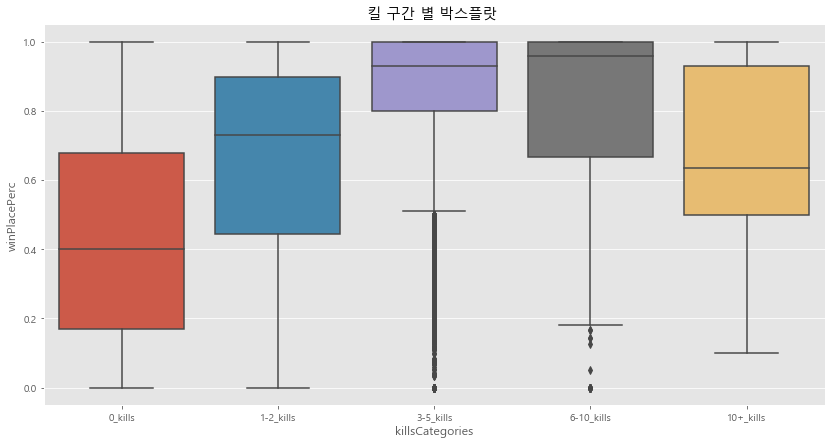

In [35]:
kills = train.copy()

kills['killsCategories'] = pd.cut(kills['assists'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(14,7))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.title('킬 구간 별 박스플랏 ')
plt.show()

### 헤드샷 (headshotKills)

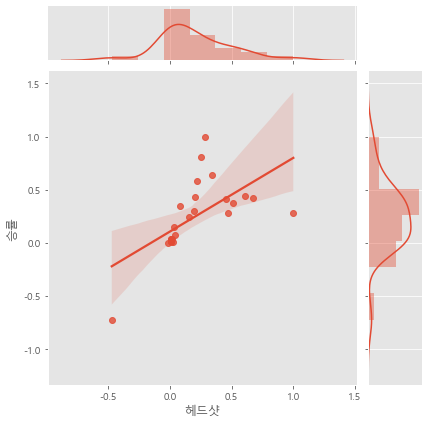

평균적인 사람의 킬의 거리는  0.2263 명의 플레이어의 수치이다., 99% 의 사람들은 3.0명 이하의 킬을 기록한 반면에 가장 많이 킬수는  18.0명이다..


In [36]:
sns.jointplot(data=train.corr(), x= 'headshotKills', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('헤드샷')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 사람의 킬의 거리는  {:.4f} 명의 플레이어의 수치이다., 99% 의 사람들은 {}명 이하의 킬을 기록한 반면에 가장 많이 킬수는  {}명이다.."
      .format(train['headshotKills'].mean(),train['headshotKills'].quantile(0.99), train['headshotKills'].max()))

### 짧은 시간동안 최대한 많이 킬했을 때의 킬 수 (killStreaks)

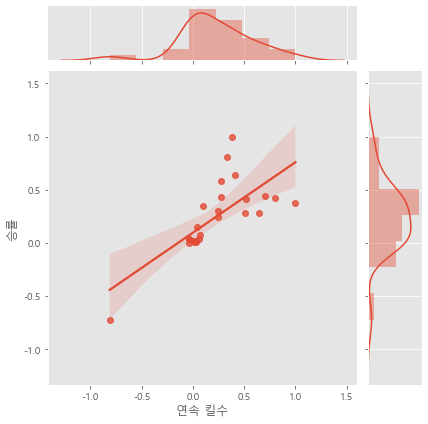

평균적인 사람의 킬의 거리는  0.5432 명의 플레이어의 수치이다., 99% 의 사람들은 3.0명 이하의 킬을 기록한 반면에 가장 많이 킬수는  10.0명이다..


In [37]:
sns.jointplot(data=train.corr(), x= 'killStreaks', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('연속 킬수')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 사람의 킬의 거리는  {:.4f} 명의 플레이어의 수치이다., 99% 의 사람들은 {}명 이하의 킬을 기록한 반면에 가장 많이 킬수는  {}명이다.."
      .format(train['killStreaks'].mean(),train['killStreaks'].quantile(0.99), train['killStreaks'].max()))

In [38]:
train[train['killStreaks']>10][['assists', 'boosts', 'heals', 'damageDealt','DBNOs', 'kills', 'headshotKills', 'killStreaks','longestKill','walkDistance','weaponsAcquired']]

,assists,boosts,heals,damageDealt,DBNOs,kills,headshotKills,killStreaks,longestKill,walkDistance,weaponsAcquired


### 킬 거리 (longestKill)

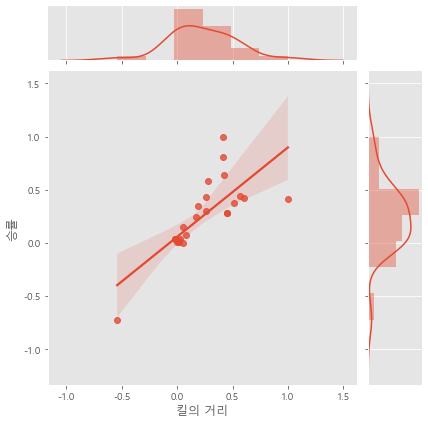

평균적인 사람의 킬의 거리는 23.0471 거리의 플레이어의 수치이다., 99% 의 사람들은 244.9 이하의 킬거리를 기록한 반면에 가장 많이 킬거리는  1072.0 이다..


In [39]:
sns.jointplot(data=train.corr(), x= 'longestKill', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('킬의 거리')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 사람의 킬의 거리는 {:.4f} 거리의 플레이어의 수치이다., 99% 의 사람들은 {} 이하의 킬거리를 기록한 반면에 가장 많이 킬거리는  {} 이다.."
      .format(train['longestKill'].mean(),train['longestKill'].quantile(0.99), train['longestKill'].max()))

### 차량 이동거리 (rideDistance)

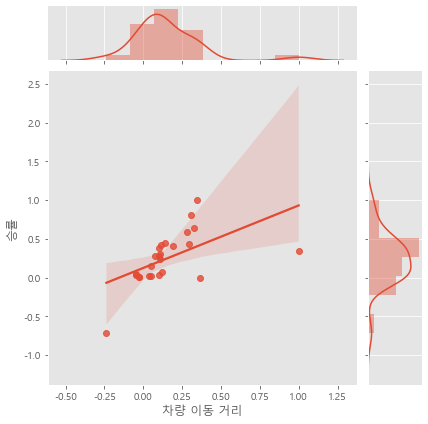

평균적인 차량 이동거리는  605.7924의 수치이다., 99% 의 사람들은 6978.0이동을 하였으며  가장 많이 이동한 거리는  35400.0이다..


In [40]:
sns.jointplot(data=train.corr(), x= 'rideDistance', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('차량 이동 거리')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 차량 이동거리는  {:.4f}의 수치이다., 99% 의 사람들은 {}이동을 하였으며  가장 많이 이동한 거리는  {}이다.."
      .format(train['rideDistance'].mean(),train['rideDistance'].quantile(0.99), train['rideDistance'].max()))

In [41]:
train[train['rideDistance']>30000][['assists', 'boosts', 'heals', 'damageDealt','DBNOs', 'kills', 'headshotKills', 'killStreaks','longestKill','rideDistance','walkDistance','weaponsAcquired']]

,assists,boosts,heals,damageDealt,DBNOs,kills,headshotKills,killStreaks,longestKill,rideDistance,walkDistance,weaponsAcquired
385638,0,7,4,196.9,0.0,1.0,0.0,1.0,85.44,30030.0,1328.00,2
426518,0,2,4,265.6,0.0,2.0,0.0,1.0,26.68,35400.0,1912.00,7
1339189,0,7,3,560.1,0.0,6.0,3.0,2.0,250.50,32450.0,969.00,5
1392119,0,0,0,0.0,0.0,0.0,0.0,0.0,0.00,31690.0,23.77,0


### 무기 획득 수 (weaponsAcquired)

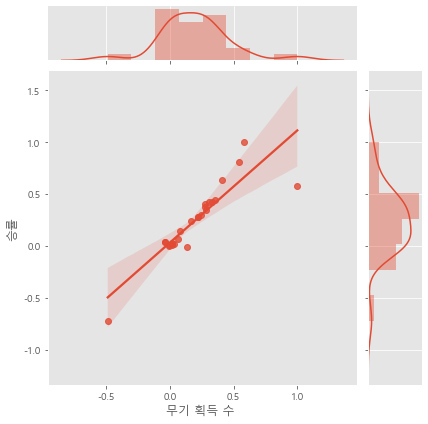

평균적인 걸음 이동거리 는  3.6566의 수치이다., 99% 의 사람들은 10.0이동을 하였으며  가장 많이 이동한 걸음 는  236이다..


In [42]:
sns.jointplot(data=train.corr(), x= 'weaponsAcquired', y = 'winPlacePerc', kind= 'reg')
plt.xlabel('무기 획득 수 ')
plt.ylabel('승률')
plt.grid()
plt.show()
print("평균적인 걸음 이동거리 는  {:.4f}의 수치이다., 99% 의 사람들은 {}이동을 하였으며  가장 많이 이동한 걸음 는  {}이다.."
      .format(train['weaponsAcquired'].mean(),train['weaponsAcquired'].quantile(0.99), train['weaponsAcquired'].max()))

In [43]:
train[train['weaponsAcquired']>150][['assists', 'boosts', 'heals', 'damageDealt','DBNOs', 'kills', 'headshotKills', 'killStreaks','longestKill','rideDistance','walkDistance','weaponsAcquired']]

,assists,boosts,heals,damageDealt,DBNOs,kills,headshotKills,killStreaks,longestKill,rideDistance,walkDistance,weaponsAcquired
859834,0,4,2,186.90,2.0,2.0,0.0,2.0,33.43,1675.0,1643.0,167
861823,1,3,5,378.90,2.0,3.0,0.0,1.0,140.50,303.7,3338.0,177
934978,0,1,2,85.85,0.0,0.0,0.0,0.0,0.00,4778.0,2112.0,236


### 승률 과 무기획득 수 
 
그래프를 보았을때 확실하게 상관관계를 다른 그래프에 비해 보기 애매하기 때문에 [승률]과 [무기획득 수]의 상관관계를 알아보도록 하자.

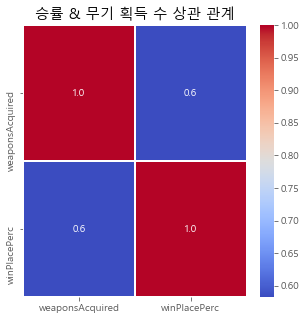

In [51]:
weapon =  train[['weaponsAcquired', 'winPlacePerc']]

f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(weapon.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap='coolwarm')
plt.title('승률 & 무기 획득 수 상관 관계')
plt.show()

 다중 선형 회귀 분석
 
 각 변수 마다 회귀 지수가 나오면 회귀 지수마다 상관계수랑 비슷한 개념인건데 각 표준화 를 시킨다 corr은 정규화다.
 \
  랜덤포레스츠 리그레이션 으로 구할 수 이는ㄴ걸 구한.
  

# train/test셋 나누기

In [44]:
# 회귀분석및 모델 훈련 결과를 얻기위해 필요한 컬럼만 남긴다
# Id,matchId,matchtype 삭제
train = train [['assists', 'boosts', 'heals', 'damageDealt','DBNOs', 'kills', 'headshotKills', 'killStreaks','longestKill', 'rideDistance','walkDistance','weaponsAcquired', 'winPlacePerc']]

x = train.iloc[:,:-1] 
y = train.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state =1234)

# 회귀분석

In [58]:
re = sm.ols(formula = 'winPlacePerc ~ assists+ boosts+ heals+ damageDealt+DBNOs+ kills+ headshotKills+ killStreaks+longestKill+ rideDistance+walkDistance+weaponsAcquired', data = train).fit()
re.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           winPlacePerc   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                 2.940e+05
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        17:09:54   Log-Likelihood:             5.4479e+05
No. Observations:             1394228   AIC:                        -1.090e+06
Df Residuals:                 1394215   BIC:                        -1.089e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1658      0.000    628.357      0.000       0.165       0.166
assists             0.0103      0.000     39.080      0.000       0.010       0.011
boosts              0.0214      0.000    174.607      0.000       0.021       0.022
heals               0.0018   6.29e-05     28.058      0.000       0.002       0.002
damageDealt         0.0001   1.98e-06     68.344      0.000       0.000       0.000
DBNOs              -0.0243      0.000   -129.569      0.000      -0.025      -0.024
kills              -0.0015      0.000     -5.975      0.000      -0.002      -0.001
headshotKills      -0.0017      0.000     -5.347      0.000      -0.002      -0.001
killStreaks         0.0370      0.000    109.704      0.000       0.036       0.038
longestKill      7.943e-05   3.56e-06     22.315      0.000    7.25e-05    8.64e-05
rideDistance     1.218e-05   1.02e-07    119.977      0.000     1.2e-05    1.24e-05
walkDistance        0.0002   1.71e-07    884.047      0.000       0.000       0.000
weaponsAcquired     0.0205   6.91e-05    296.249      0.000       0.020       0.021
==============================================================================
Omnibus:                   124311.152   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           522360.060
Skew:                           0.365   Prob(JB):                         0.00
Kurtosis:                       5.908   Cond. No.                     5.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

위 결과에서 R-squared 값은 71.6%로 설명력이 높으며 모형에 대한 p-value 또한 0.05보다 낮으므로 통계적으로 유의하다.

## 모형 적합도
- R-squared: 0.716

 -  R제곱
 - 모형 적합도(혹은 설명력)
 - 승률의 분산을 각각의 컬림들이 약 71.6%를 설명한다
 - 각 사례마다 승률 차이가 있다.
<br>
<br>
- Adj. R-squared: 0.716

 - 독립변수가 여러 개인 다중회귀분석에서 사용
 - 독립변수의 개수와 표본의 크기를 고려하여 R-squared를 보정
 - 서로 다른 모형을 비교할 때는 이 지표가 높은 쪽은 선택한다
<br>
<br>
- F-statistic: 2.054e+05, Prob(F-statistic):  0.00

 - 회귀모형에 대한 (통계적) 유의미성 검증 결과, 유의미함 (p < 0.05)
 - 즉, 이 모형은 주어진 표본 뿐 아니라 모집단에서도 의미있는 모형이라 할 수 있음
 <br>
 <br>
- 로그 우도: 종속변수가 정규분포라 가정했을 때 그 우도

 - 로그우도도 R제곱과 마찬가지로 독립변수가 많아지면 증가한다
 - AIC, BIC: 로그우도를 독립변수의 수로 보정한 값 (작을 수록 좋다)

Coef는 데이터로부터 얻은 계수의 추정치를 말한다.

절편(Intercept)의 추정치는  0.1661로, speed가 0일 때 dist의 값이다.

- assists     계수 추정치는 0.0103  assists 1    증가할 때마다 dist가 0.0103  증가한다는 것을 의미한다.
- boosts      계수 추정치는 0.0216 boosts 1      증가할 때마다 dist가  0.0216 증가한다는 것을 의미한다.
- heals       계수 추정치는 0.0017 heals 1       증가할 때마다 dist가 0.0017  증가한다는 것을 의미한다.
- damageDealt 계수 추정치는 0.0001 damageDealt 1 증가할 때마다 dist가 0.0001  증가한다는 것을 의미한다.
- DBNOs       계수 추정치는 -0.0245 DBNOs  1        증가할 때마다 dist가 -0.0245    증가한다는 것을 의미한다.
- kills       계수 추정치는  -0.0015  speed가 1       증가할 때마다 dist가  -0.0015     증가한다는 것을 의미한다.
- headshotKills      계수 추정치는 -0.0022 speed가 1       증가할 때마다 dist가 -0.0022    증가한다는 것을 의미한다.
- killStreaks      계수 추정치는 0.0374  speed가 1       증가할 때마다 dist가 0.0374     증가한다는 것을 의미한다.
- longestKill       계수 추정치는 8.299e-05 speed가 1       증가할 때마다 dist가 8.299e-05    증가한다는 것을 의미한다.
- rideDistance        계수 추정치는 1.218e-05 speed가 1       증가할 때마다 dist가 1.218e-05    증가한다는 것을 의미한다.
- walkDistance       계수 추정치는 0.0002 speed가 1       증가할 때마다 dist가 0.0002    증가한다는 것을 의미한다.
- weaponsAcquired        계수 추정치는  0.0203 speed가 1       증가할 때마다 dist가  0.0203    증가한다는 것을 의미한다.
<br>

**회귀분석을 실시한 결과, train 데이터의 컬럼의 P-vlaue의 값들은 0.000이기 때문에 회귀모형은 통계적으로 유의미하였다(p < 0.05).**

## 선형회귀 모델

In [59]:
from sklearn.datasets import load_boston
boston = load_boston()
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression


In [60]:
# 모델 생성과 학습
lr = LinearRegression()
lr.fit(x_train, y_train)

print('훈련 세트 점수 : {:.8f}'.format(lr.score(x_train, y_train)))
print('테스트 세트 점수:{:.8f}'.format(lr.score(x_test, y_test)))

훈련 세트 점수 : 0.71697745
테스트 세트 점수:0.71622684


## 적합도 검증

In [61]:
X = train[['assists', 'boosts', 'heals', 'damageDealt', 'DBNOs', 'kills',
       'headshotKills', 'killStreaks', 'longestKill', 'rideDistance',
       'walkDistance', 'weaponsAcquired']]                   
# 독립변수들을 따로 변수에 저장. "data"데이터 프레임 안에 독립변수 "x1"과 "x2"를 "X"라는 변수에 저장.

y = train['winPlacePerc']

In [62]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X = pd.DataFrame(X), y = y)
prediction = linear_regression.predict(X = pd.DataFrame(X))
print('a value = ', linear_regression.intercept_)
print('b value = ', linear_regression.coef_)

# 적합도 검증 - 잔차
residuals = train["winPlacePerc"] - prediction
residuals.describe().round()

a value =  0.16579154133095803
b value =  [ 1.03401843e-02  2.14081482e-02  1.76378064e-03  1.35652901e-04
 -2.43275398e-02 -1.49952700e-03 -1.68815042e-03  3.69985335e-02
  7.94339940e-05  1.21816038e-05  1.50979756e-04  2.04619480e-02]


count    1394228.0
mean           0.0
std            0.0
min           -5.0
25%           -0.0
50%           -0.0
75%            0.0
max            1.0
Name: winPlacePerc, dtype: float64

## 적합도 검증 - 결정계수

In [63]:
# 적합도 검증 - 결정계수

SSE = (residuals**2).sum()
SST = ((y-y.mean())**2).sum()
R_squared = 1 - (SSE/SST)
print('R_squared = ', R_squared)

R_squared =  0.7167572854654112


**R_squared는 71.6%는 독립변수들이 종속변수에 상당한 영향을 주는 것을 말한다**

# RandomForestRegressor

정규화 된 데이터를 랜덤포레스트로 작성 

In [64]:
# 랜덤포레스트 리그레이션 깊이: 6, 훈련량: 500
rf = RandomForestRegressor(random_state=1234, max_depth= 6, n_estimators=500)
#훈련
rf.fit(x_train, y_train)
# 예측
rf_pred = rf.predict(x_test)

In [65]:
# 정확도
print('RandomForest 정확도: {:.8f}'.format(rf.score(x_train, y_train)))

# mse
mse = mean_squared_error(y_test, rf_pred)

# rmse
rmse = np.sqrt(mse)
rmse

RandomForest 정확도: 0.77747788


0.14586397575710158

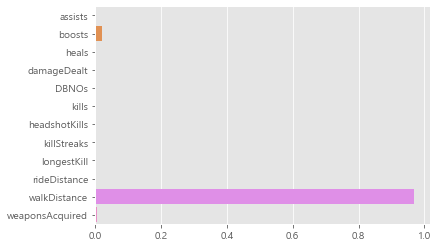

In [66]:
# 그래프 그리기 
feature_names = x_train.columns.tolist()
sns.barplot(x=rf.feature_importances_, y = feature_names)

# Gradient Boost 

Gradient Boost는 회귀와 분류에 모두 사용할 수 있는 모델입니다.

랜덤 포레스트와는 달리 그래디언트 부스팅은 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만듭니다.

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
# 그레디언트 부스트 깊이: 6, 훈련량: 500
gbrt = GradientBoostingRegressor(random_state=1234, max_depth= 6, n_estimators=500) # learning_rate 기본값 0.1
# 훈련
gbrt.fit(x_train, y_train)
# 예측
gbrt_pred = gbrt.predict(x_test)

In [46]:
# 정확도
print('Gradient Boost 정확도: {:.8f}'.format(gbrt.score(x_train, y_train)))

# mse
mse = mean_squared_error(y_test, gbrt_pred)

# rmse
rmse = np.sqrt(mse)
rmse

Gradient Boost 정확도: 0.79822008


0.14065283398714534

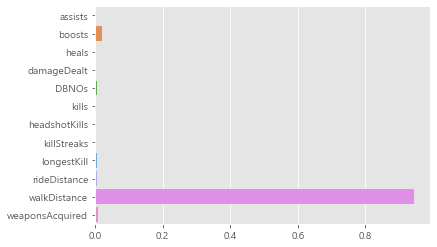

In [47]:
gbrt.feature_importances_
feature_names = x_train.columns.tolist()

sns.barplot(x=gbrt.feature_importances_, y = feature_names)

# XGBOOST

In [48]:
# XGBOOST 깊이: 6, 훈련량: 500
xgb = XGBRegressor(random_state=1234, max_depth= 6, n_estimators=500)
# 학습
xgb.fit(x_train, y_train)
# 예측
xgb_pred = xgb.predict(x_test)

In [49]:
# 정확도
print('XGBOOST 정확도: {:.8f}'.format(xgb.score(x_train, y_train)))

# mse
mse = mean_squared_error(y_test, xgb_pred)

# rmse
rmse = np.sqrt(mse)
rmse

XGBOOST 정확도: 0.80409179


0.14116756433723623

In [50]:
xgb.feature_importances_

array([0.00986572, 0.07353523, 0.00908303, 0.00576562, 0.02776495,
       0.02671513, 0.00256839, 0.00615626, 0.01070692, 0.0090246 ,
       0.79861844, 0.0201957 ], dtype=float32)

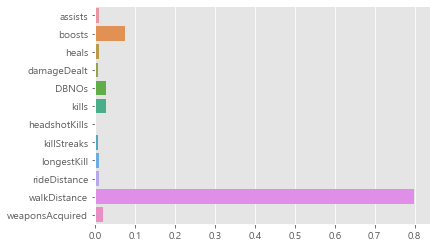

In [51]:
# 그래프 그리기
feature_names = x_train.columns.tolist()

sns.barplot(x=xgb.feature_importances_, y = feature_names)

# 모델별 정확도 확인


## RandomForestRegressor

- 정확도: 0.77747788
- RMSE:   0.14586397575710158

##  Gradient Boost 

- 정확도:   0.79822008
- RMSE: 0.14065283398714534

## XGBOOST

- 정확도:   0.80409179
- RMSE: 0.14116756433723623


## 하이퍼파라미터(xgboost)

- 최적모델찾기 
- 파라미터 찾은 걸로 다시 돌려보기
- https://statkclee.github.io/model/model-python-xgboost-hyper.html < 맨아래 초모수 시각화

In [135]:
xgb1 = XGBRegressor()

xgb1_param_grid = {
    'n_estimators' : [100, 200, 400, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15],
    'max_depth' : [2, 4, 5, 7, 9, 10],
}

In [137]:
xgb1_grid = GridSearchCV(xgb1, param_grid = xgb1_param_grid, n_jobs=-1, verbose = 1)
xgb1_grid.fit(x_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 196.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 484.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 551.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_est...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=Non

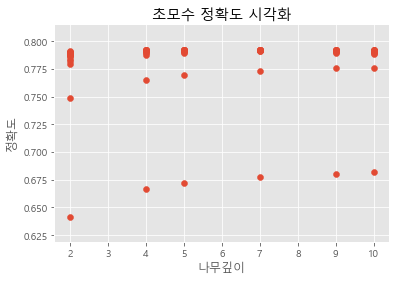

In [146]:
%matplotlib inline 

plt.scatter(y=cv_result_df['mean_test_score'], x=cv_result_df['param_max_depth'])  
plt.gca().set(xlabel='나무깊이', ylabel='정확도', title='초모수 정확도 시각화')
plt.show()

In [139]:
print("최고 평균 정확도 : {0:.8f}".format(xgb1_grid.best_score_))
print("최고의 파라미터 : ", xgb1_grid.best_params_)

최고 평균 정확도 : 0.79251252
최고의 파라미터 :  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 400}


In [143]:
cv_result_df = pd.DataFrame(xgb1_grid.cv_results_)
cv_result_df.sort_values(by=['rank_test_score'], inplace=True)

In [145]:
cv_result_df[['params', 'mean_test_score', 'rank_test_score']].head(10)

,params,mean_test_score,rank_test_score
38,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est...",0.792513,1
39,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est...",0.792449,2
37,"{'learning_rate': 0.05, 'max_depth': 7, 'n_est...",0.792439,3
35,"{'learning_rate': 0.05, 'max_depth': 5, 'n_est...",0.792437,4
58,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.792434,5
59,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.792426,6
61,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.792394,7
55,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.792385,8
60,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.792362,9
79,"{'learning_rate': 0.15, 'max_depth': 4, 'n_est...",0.792326,10


## K-FOLD 교차검증 

In [53]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5) # KFold 객체 생성
logreg = XGBRegressor(random_state=1234, learning_rate = 0.05,
                     max_depth = 7, n_estimators = 400) # 모델 객체 생성

for n in [3, 5]:
    kfold = KFold(n_splits=n, random_state=1234, shuffle=True)
    scores = cross_val_score(logreg, x, y, cv=kfold)
    print('n_splits={}, cross validation score: {}'.format(n, scores))

n_splits=3, cross validation score: [0.79183499 0.79189537 0.7926863 ]
n_splits=5, cross validation score: [0.79120763 0.79233143 0.79266873 0.79156059 0.79346288]


In [61]:
print('n_splits={}, 교차검증 점수 : {}'.format(n, np.mean(scores)))

n_splits=5, 교차검증 점수 : 0.7922462521305114


-  K-FOLD 교차검증 : 0.7922462521305114

#  승률 예측

In [62]:
# 훈련량: 400, 학습률:0.05, 깊이: 7
xgb2 = XGBRegressor(random_state=1234, n_estimators = 400, learning_rate = 0.05, max_depth = 7)

# 학습
xgb2.fit(x_train, y_train)
# 예측
xgb2_pred = xgb2.predict(x_test)

In [63]:
# 정확도
print('XGBOOST 정확도: {:.8f}'.format(xgb2.score(x_train, y_train)))

# mse
mse = mean_squared_error(y_test, xgb2_pred)

# rmse
rmse = np.sqrt(mse)
rmse

XGBOOST 정확도: 0.79710153


0.1405786606998235

In [64]:
xgb2.feature_importances_

array([0.00660924, 0.05586796, 0.00708277, 0.00419902, 0.0137675 ,
       0.01543529, 0.00101011, 0.00279846, 0.00899406, 0.00626262,
       0.86338896, 0.01458406], dtype=float32)

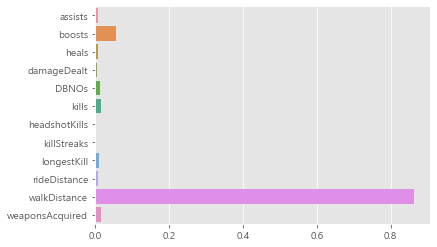

In [65]:
feature_names = x_train.columns.tolist()

sns.barplot(x=xgb2.feature_importances_, y = feature_names)

# 결과

- RMSE: 0.1405786606998235


# 프로젝트를 통해 느낀점

- 머신러닝 모델에 대해서 좀더 자세히 알지 못하여 제대로 적용을 못시킨거 같아 아쉬웠다. 
- 게임 업계의 데이터 분석을 하게되면 어떻게 하게되는데 간접 적으로 체험을 할 수 있는 계기과 어떤 부분을 잘 알고 모르는지 알게 되는 계기였다.